# League of Legends Match Predictor

### Introduction
League of Legends, a popular multiplayer online battle arena (MOBA) game, generates extensive data from matches, providing an excellent opportunity to apply machine learning techniques to real-world scenarios. Perform the following steps to build a logistic regression model aimed at predicting the outcomes of League of Legends matches. 

In [25]:
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset


In [26]:
data_path = Path(Path.cwd()).resolve().parents[0] / "project" / "league_of_legends_data_large.csv"


df = pd.read_csv(data_path)
X = df.drop('win', axis=1)
y = df['win']

display(X)
display(y)

,kills,deaths,assists,gold_earned,cs,wards_placed,wards_killed,damage_dealt
0,16,6,19,17088,231,11,7,15367
1,8,8,5,14865,259,10,2,38332
2,0,17,11,15919,169,14,5,24642
3,19,11,1,11534,264,14,3,15789
4,12,7,6,18926,124,15,7,40268
...,...,...,...,...,...,...,...,...
995,2,15,12,17170,294,8,6,33469
996,5,13,4,19524,236,14,3,8845
997,8,7,8,7961,139,11,7,49650
998,5,17,5,8226,193,9,9,28290


0      0
1      1
2      0
3      0
4      0
      ..
995    0
996    0
997    1
998    1
999    0
Name: win, Length: 1000, dtype: int64

### Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
display(f'X_train shape: {X_train.shape}')
display(f'y_train shape: {y_train.shape}')
display(f'X_test shape: {X_test.shape}')
display(f'y_test shape: {y_test.shape}')


'X_train shape: (800, 8)'

'y_train shape: (800,)'

'X_test shape: (200, 8)'

'y_test shape: (200,)'

### Standardize the feature using StandardScaler

In [28]:
scaler = StandardScaler()
# Fit the scaler on the training data and transform it
X_train = scaler.fit_transform(X_train)
# Transform the test data using the same scaler
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


# Create DataLoader for training and test sets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



### Logistic Regression Model

In [29]:
import torch.nn as nn

class LogisticRegressionNet(nn.Module):
    
    # Constructor
    def __init__(self, n_inputs):
        super(LogisticRegressionNet, self).__init__()
        self.linear = nn.Linear(n_inputs, 1)
        
    # Prediction
    def forward(self, x):
        yhat = torch.sigmoid(self.linear(x))
        return yhat

# Instantiate the model

input_dim = X_train.shape[1]  # Number of features

model = LogisticRegressionNet(n_inputs=input_dim)


In [30]:
print(model)

LogisticRegressionNet(
  (linear): Linear(in_features=8, out_features=1, bias=True)
)


In [31]:
import torch.optim as optim

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [32]:
epochs = 1000
train_losses = []
test_losses = []

In [33]:


for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1).float()
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        # Optional: calculate accuracy inline
        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_binary = (val_preds > 0.5).float()
            val_acc = (val_binary == y_test).float().mean().item()
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {val_acc:.4f}')





Epoch [100/1000], Train Loss: 0.6906, Test Loss: 0.6773, Test Acc: 0.5450
Epoch [200/1000], Train Loss: 0.6907, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [300/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5400
Epoch [400/1000], Train Loss: 0.6907, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [500/1000], Train Loss: 0.6907, Test Loss: 0.6774, Test Acc: 0.5450
Epoch [600/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5400
Epoch [700/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5350
Epoch [800/1000], Train Loss: 0.6906, Test Loss: 0.6775, Test Acc: 0.5400
Epoch [900/1000], Train Loss: 0.6906, Test Loss: 0.6775, Test Acc: 0.5350
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6774, Test Acc: 0.5350


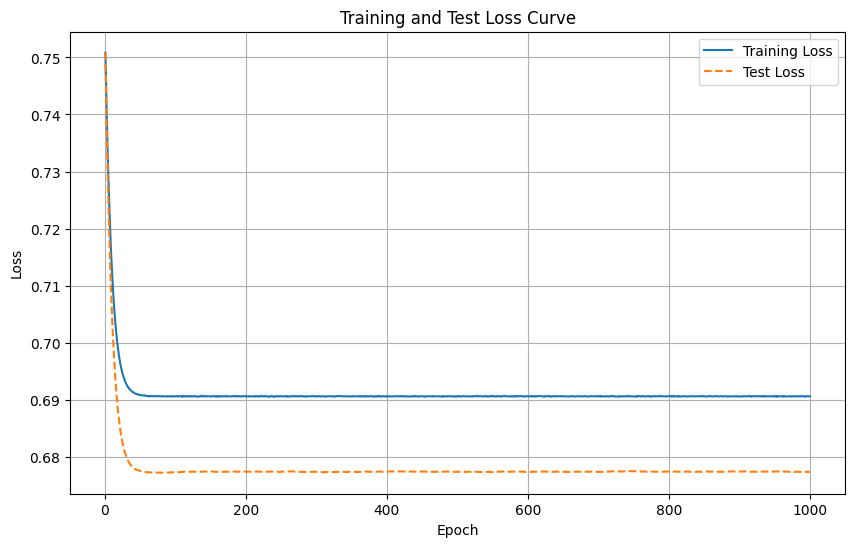

In [34]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

The training and test loss curve shows that both losses decrease rapidly during the first ~50 epochs, indicating that the model quickly learns basic patterns. 

Around epoch 100, both losses plateau—training loss stabilizes near 0.689, while test loss levels off slightly lower around 0.678. 

Interestingly, the test loss remains below the training loss, which is uncommon but acceptable in logistic regression, especially when regularization, data noise, or class imbalance are present. 

This suggests the model generalizes well and is not overfitting. However, the relatively high loss values indicate weak predictive signals in the data.

In [35]:

model.eval()
with torch.no_grad():
    # Get predictions on training set
    train_predictions = model(X_train)
    
    # Get predictions on test set  
    test_predictions = model(X_test)

# The predictions are probabilities (0 to 1) from sigmoid
print("Raw predictions (probabilities):")
print(f"Train predictions shape: {train_predictions.shape}")
print(f"Test predictions shape: {test_predictions.shape}")
print(f"Sample train predictions: {train_predictions[:5].flatten()}")
print(f"Sample test predictions: {test_predictions[:5].flatten()}")

# Convert probabilities to binary predictions (0 or 1)
# Using threshold of 0.5
train_pred_binary = (train_predictions > 0.5).float()
test_pred_binary = (test_predictions > 0.5).float()

print(f"\nBinary predictions (0 or 1):")
print(f"Sample train binary predictions: {train_pred_binary[:5].flatten()}")
print(f"Sample test binary predictions: {test_pred_binary[:5].flatten()}")

# Calculate accuracy
train_accuracy = (train_pred_binary == y_train).float().mean()
test_accuracy = (test_pred_binary == y_test).float().mean()

print(f"\nModel Performance:")
print(f"Training Accuracy: {train_accuracy.item():.4f} ({train_accuracy.item()*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy.item():.4f} ({test_accuracy.item()*100:.2f}%)")

Raw predictions (probabilities):
Train predictions shape: torch.Size([800, 1])
Test predictions shape: torch.Size([200, 1])
Sample train predictions: tensor([0.5684, 0.5011, 0.4865, 0.5669, 0.4956])
Sample test predictions: tensor([0.5175, 0.5016, 0.5204, 0.5164, 0.5478])

Binary predictions (0 or 1):
Sample train binary predictions: tensor([1., 1., 0., 1., 0.])
Sample test binary predictions: tensor([1., 1., 1., 1., 1.])

Model Performance:
Training Accuracy: 0.5238 (52.38%)
Test Accuracy: 0.5350 (53.50%)


### Model Optimization

In [36]:
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)
epochs = 1000
train_losses = []
test_losses = []



for epoch in range(epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        y_batch = y_batch.view(-1, 1).float()
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluation phase on test set
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_batch = y_batch.view(-1, 1).float()
            test_outputs = model(X_batch)
            loss = criterion(test_outputs, y_batch)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    
    if (epoch + 1) % 100 == 0:
        # Optional: calculate accuracy inline
        model.eval()
        with torch.no_grad():
            val_preds = model(X_test)
            val_binary = (val_preds > 0.5).float()
            val_acc = (val_binary == y_test).float().mean().item()
        print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {val_acc:.4f}')






Epoch [100/1000], Train Loss: 0.6907, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [200/1000], Train Loss: 0.6907, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [300/1000], Train Loss: 0.6906, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [400/1000], Train Loss: 0.6907, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [500/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [600/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [700/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [800/1000], Train Loss: 0.6907, Test Loss: 0.6780, Test Acc: 0.5400
Epoch [900/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400
Epoch [1000/1000], Train Loss: 0.6906, Test Loss: 0.6779, Test Acc: 0.5400


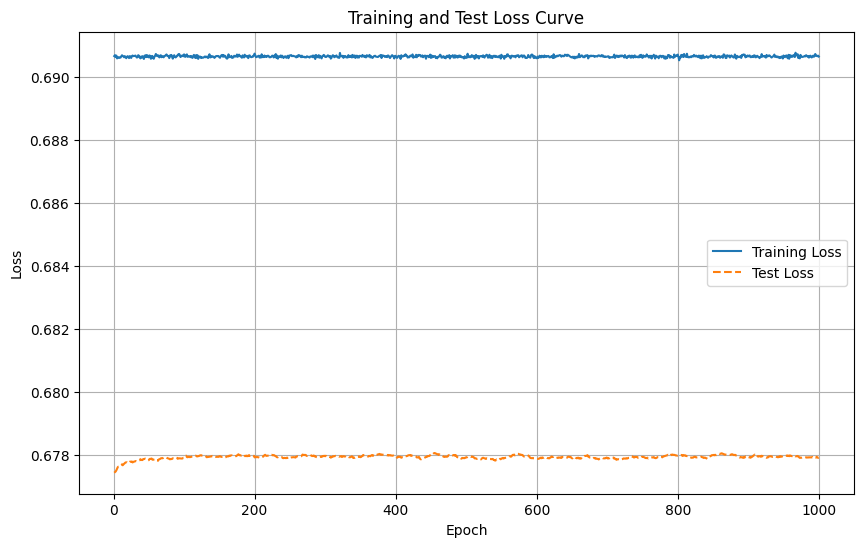

In [37]:
import matplotlib.pyplot as plt

# Plot the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Test Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

### Visualization and Interpretation

In [38]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

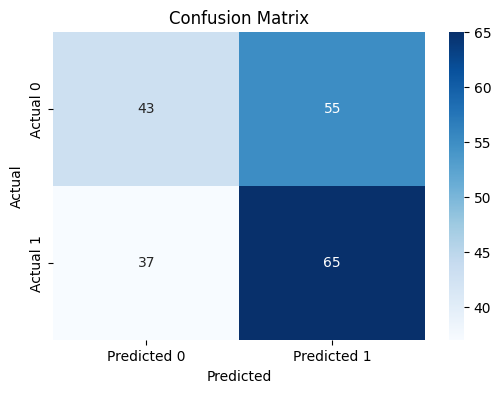

In [40]:
# Confusion Matrix
cm = confusion_matrix(y_test, val_binary)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

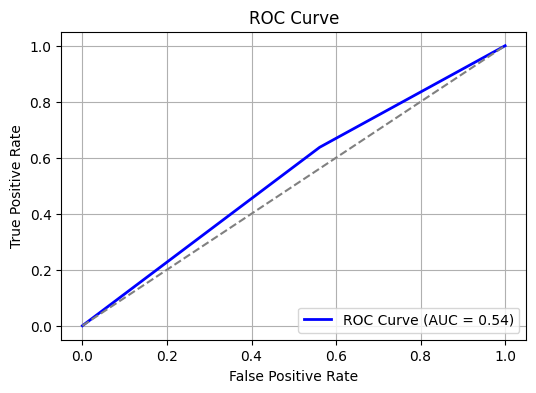

In [41]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, val_binary)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [42]:
# Classification Report
report = classification_report(y_test, val_binary, target_names=["Class 0", "Class 1"])
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.54      0.44      0.48        98
     Class 1       0.54      0.64      0.59       102

    accuracy                           0.54       200
   macro avg       0.54      0.54      0.53       200
weighted avg       0.54      0.54      0.54       200



### Save the Model

In [43]:
# Save the model's learned parameters (state_dict)
torch.save(model.state_dict(), 'logistic_model.pth')
print("Model saved successfully.")


Model saved successfully.


In [45]:
# Recreate the model structure
loaded_model = LogisticRegressionNet(n_inputs=X_train.shape[1])  # Make sure input dim is the same

# Load the saved weights into the new model instance
loaded_model.load_state_dict(torch.load('logistic_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()
print("Model loaded and set to eval mode.")


Model loaded and set to eval mode.


In [46]:
# Evaluate the loaded model on test data
with torch.no_grad():
    test_preds = loaded_model(X_test)
    test_preds_label = (test_preds > 0.5).float()

# Calculate accuracy
test_acc = (test_preds_label == y_test).float().mean().item()

print(f"Loaded Model Test Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")


Loaded Model Test Accuracy: 0.5400 (54.00%)


### Hyperparameter tuning

In [47]:
learning_rates = [0.01, 0.05, 0.1]
num_epochs = 100
best_acc = 0
best_lr = None
results = {}

for lr in learning_rates:
    print(f"\nTraining with learning rate: {lr}")

    
    model = LogisticRegressionNet(n_inputs=X_train.shape[1])
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

   
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            y_batch = y_batch.view(-1, 1).float()
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    
    model.eval()
    with torch.no_grad():
        test_preds = model(X_test)
        test_preds_label = (test_preds > 0.5).float()
        test_acc = (test_preds_label == y_test).float().mean().item()
        results[lr] = test_acc
        print(f"Test Accuracy for lr={lr}: {test_acc:.4f}")

        if test_acc > best_acc:
            best_acc = test_acc
            best_lr = lr


print("\nSummary of Results:")
for lr, acc in results.items():
    print(f"Learning Rate: {lr} -> Test Accuracy: {acc:.4f}")

print(f"\n Best Learning Rate: {best_lr} with Accuracy: {best_acc:.4f}")



Training with learning rate: 0.01
Test Accuracy for lr=0.01: 0.5300

Training with learning rate: 0.05
Test Accuracy for lr=0.05: 0.5300

Training with learning rate: 0.1
Test Accuracy for lr=0.1: 0.5300

Summary of Results:
Learning Rate: 0.01 -> Test Accuracy: 0.5300
Learning Rate: 0.05 -> Test Accuracy: 0.5300
Learning Rate: 0.1 -> Test Accuracy: 0.5300

 Best Learning Rate: 0.01 with Accuracy: 0.5300


### Code Feature Importance and Extraction and Visualization


Feature Importance:
        Feature  Importance
7  damage_dealt   -0.093324
5  wards_placed    0.071175
0         kills    0.065932
3   gold_earned    0.061647
4            cs   -0.018369
2       assists    0.008243
6  wards_killed   -0.004358
1        deaths   -0.002820


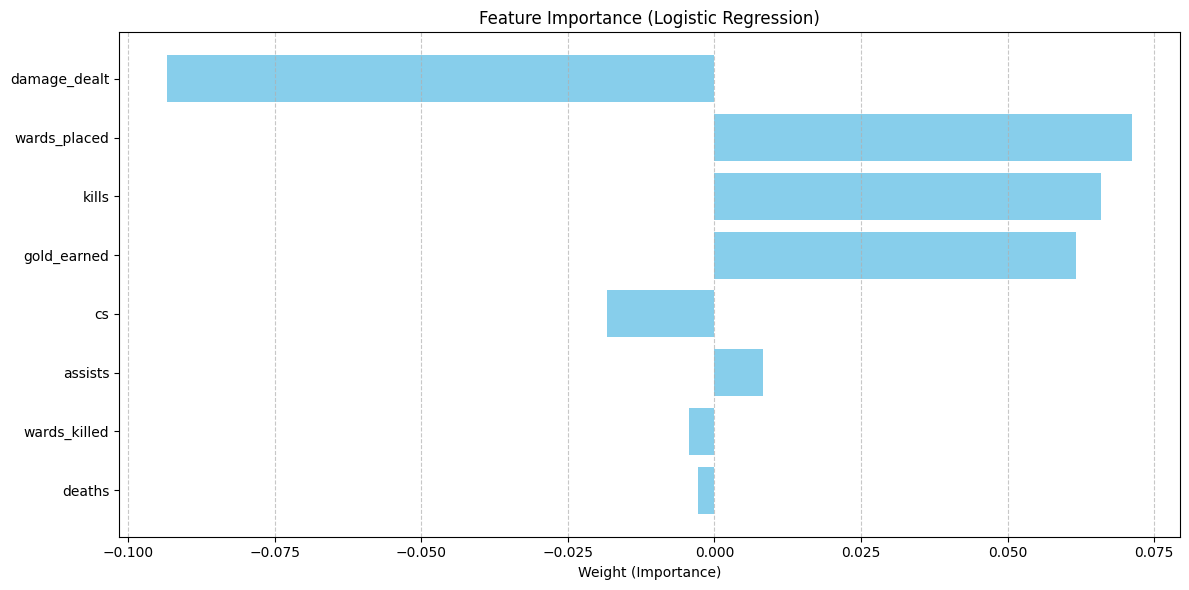

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


weights = model.linear.weight.data.numpy().flatten()  
features = X.columns  


feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': weights
})


feature_importance['Abs_Importance'] = feature_importance['Importance'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Importance', ascending=False)


print("\nFeature Importance:")
print(feature_importance[['Feature', 'Importance']])


plt.figure(figsize=(12, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.xlabel('Weight (Importance)')
plt.title('Feature Importance (Logistic Regression)')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Positive Weights:** Features with positive influence toward predicting win = 1.

**Negative Weights:** Features with negative influence (more likely to predict win = 0).

**Larger Magnitude** = Higher impact (whether positive or negative).

### Scratch


In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
# Load the dataset
data = pd.read_csv('league_of_legends_data_large.csv')
# Preprocess the data
X = data.drop('win', axis=1)
y = data['win']
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Convert to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
print("Data loading, splitting, and standardization complete.")

Data loading, splitting, and standardization complete.


In [50]:
import torch.nn as nn
import torch.optim as optim

# Define the logistic regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

# Initialize the model, loss function, and optimizer
input_dim = X_train.shape[1]
model = LogisticRegressionModel(input_dim)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

print("Model, loss function, and optimizer initialization complete.")

Model, loss function, and optimizer initialization complete.


In [51]:
# Training the model
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Model evaluation
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).detach()
    y_pred_test = model(X_test).detach()
    
train_accuracy = ((y_pred_train > 0.5) == y_train).float().mean()
test_accuracy = ((y_pred_test > 0.5) == y_test).float().mean()

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [100/1000], Loss: 0.7175
Epoch [200/1000], Loss: 0.7052
Epoch [300/1000], Loss: 0.6975
Epoch [400/1000], Loss: 0.6927
Epoch [500/1000], Loss: 0.6898
Epoch [600/1000], Loss: 0.6880
Epoch [700/1000], Loss: 0.6869
Epoch [800/1000], Loss: 0.6863
Epoch [900/1000], Loss: 0.6859
Epoch [1000/1000], Loss: 0.6856
Train Accuracy: 0.5487
Test Accuracy: 0.5250


In [52]:
# Implementing L2 regularization (Ridge Regression)
optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=0.01)

# Retrain the model with L2 regularization
epochs = 1000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Evaluate the optimized model
model.eval()
with torch.no_grad():
    y_pred_train = model(X_train).detach()
    y_pred_test = model(X_test).detach()
    
train_accuracy = ((y_pred_train > 0.5) == y_train).float().mean()
test_accuracy = ((y_pred_test > 0.5) == y_test).float().mean()

print(f'Train Accuracy: {train_accuracy:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch [100/1000], Loss: 0.6855
Epoch [200/1000], Loss: 0.6854
Epoch [300/1000], Loss: 0.6853
Epoch [400/1000], Loss: 0.6853
Epoch [500/1000], Loss: 0.6853
Epoch [600/1000], Loss: 0.6853
Epoch [700/1000], Loss: 0.6853
Epoch [800/1000], Loss: 0.6853
Epoch [900/1000], Loss: 0.6853
Epoch [1000/1000], Loss: 0.6853
Train Accuracy: 0.5475
Test Accuracy: 0.5100


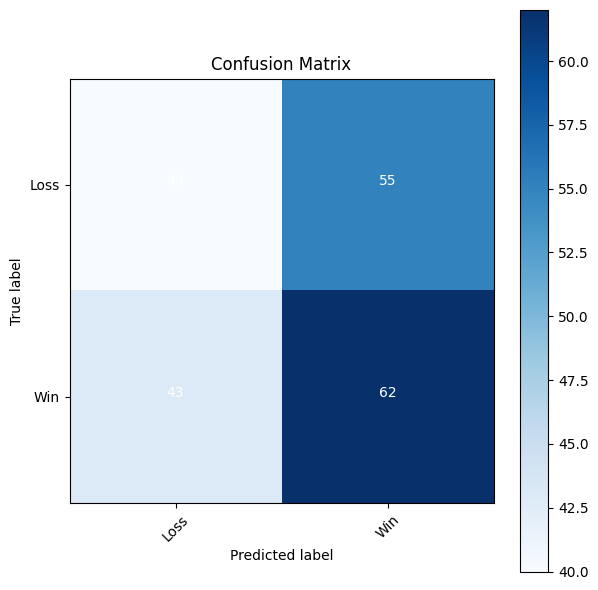

Classification Report:
               precision    recall  f1-score   support

        Loss       0.48      0.42      0.45        95
         Win       0.53      0.59      0.56       105

    accuracy                           0.51       200
   macro avg       0.51      0.51      0.50       200
weighted avg       0.51      0.51      0.51       200



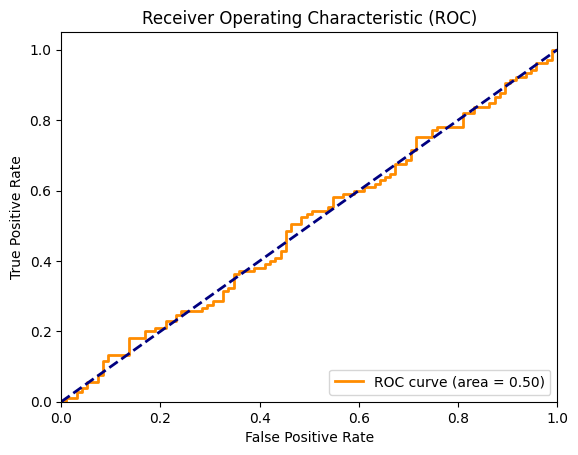

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import itertools

# Visualize the confusion matrix
y_pred_test_labels = (y_pred_test > 0.5).float()
cm = confusion_matrix(y_test, y_pred_test_labels)

plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(2)
plt.xticks(tick_marks, ['Loss', 'Win'], rotation=45)
plt.yticks(tick_marks, ['Loss', 'Win'])

thresh = cm.max() / 2
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Print classification report
print("Classification Report:\n", classification_report(y_test, y_pred_test_labels, target_names=['Loss', 'Win']))

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [54]:
# Save the model
torch.save(model.state_dict(), 'logistic_regression_model.pth')

# Load the model
loaded_model = LogisticRegressionModel(input_dim)
loaded_model.load_state_dict(torch.load('logistic_regression_model.pth'))

# Ensure the loaded model is in evaluation mode
loaded_model.eval()

# Evaluate the loaded model
with torch.no_grad():
    y_pred_test_loaded = loaded_model(X_test).detach()
    loaded_test_accuracy = ((y_pred_test_loaded > 0.5) == y_test).float().mean()
    print(f'Loaded Model Test Accuracy: {loaded_test_accuracy:.4f}')


Loaded Model Test Accuracy: 0.5100


In [55]:
learning_rates = [0.01, 0.05, 0.1]
best_accuracy = 0
best_lr = 0

for lr in learning_rates:
    # Reinitialize the model and optimizer for each learning rate
    model = LogisticRegressionModel(input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    # Training the model
    epochs = 1000
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 100 == 0:
            print(f'Learning Rate: {lr}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
    
    # Evaluate the model
    model.eval()
    with torch.no_grad():
        y_pred_test = model(X_test).detach()
        test_accuracy = ((y_pred_test > 0.5) == y_test).float().mean()
        print(f'Learning Rate: {lr}, Test Accuracy: {test_accuracy:.4f}')
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_lr = lr

print(f'Best Learning Rate: {best_lr}, Best Test Accuracy: {best_accuracy:.4f}')

Learning Rate: 0.01, Epoch [100/1000], Loss: 0.7366
Learning Rate: 0.01, Epoch [200/1000], Loss: 0.7169
Learning Rate: 0.01, Epoch [300/1000], Loss: 0.7046
Learning Rate: 0.01, Epoch [400/1000], Loss: 0.6970
Learning Rate: 0.01, Epoch [500/1000], Loss: 0.6924
Learning Rate: 0.01, Epoch [600/1000], Loss: 0.6896
Learning Rate: 0.01, Epoch [700/1000], Loss: 0.6879
Learning Rate: 0.01, Epoch [800/1000], Loss: 0.6869
Learning Rate: 0.01, Epoch [900/1000], Loss: 0.6863
Learning Rate: 0.01, Epoch [1000/1000], Loss: 0.6859
Learning Rate: 0.01, Test Accuracy: 0.5150
Learning Rate: 0.05, Epoch [100/1000], Loss: 0.6894
Learning Rate: 0.05, Epoch [200/1000], Loss: 0.6856
Learning Rate: 0.05, Epoch [300/1000], Loss: 0.6853
Learning Rate: 0.05, Epoch [400/1000], Loss: 0.6853
Learning Rate: 0.05, Epoch [500/1000], Loss: 0.6852
Learning Rate: 0.05, Epoch [600/1000], Loss: 0.6852
Learning Rate: 0.05, Epoch [700/1000], Loss: 0.6852
Learning Rate: 0.05, Epoch [800/1000], Loss: 0.6852
Learning Rate: 0.05,

        Feature  Importance
3   gold_earned    0.175341
0         kills    0.130975
5  wards_placed    0.106087
1        deaths   -0.005131
4            cs   -0.007268
2       assists   -0.013663
7  damage_dealt   -0.018873
6  wards_killed   -0.034605


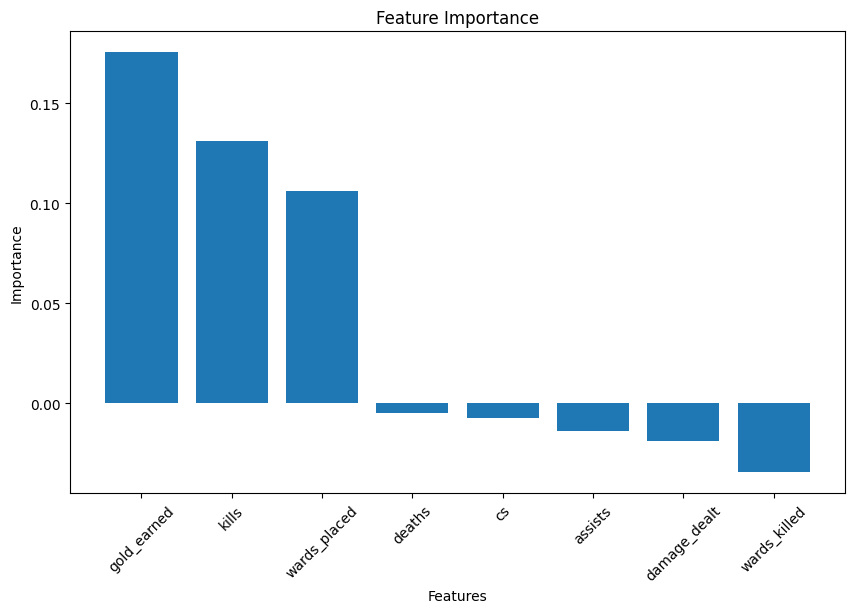

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Extract the weights of the linear layer
weights = model.linear.weight.data.numpy().flatten()
features = X.columns

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({'Feature': features, 'Importance': weights})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()